# Соревнование Kaggle [SF-DST] Booking reviews

## Описание:
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель. 

## Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.
Срок выполнения соревнования устанавливается индивидуально в каждом потоке.
Тестовая выборка представлена в LeaderBoard целиком.
Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

# Подготовка

Решение подготовлено на основе предоставленного обучающей организацией [базового решения](https://www.kaggle.com/code/mamonmega/baseline-v1). Значение метрики MAPE базового решения составило 14.134806134259833. Цель данного проекта - улучшить базовое решение таким образом, чтобы значение метрики MAPE стало менее 13.5.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# немного поменяем настройки отображения в pandas, чтобы было видно все столбцы и не ограничивалось отображение каждого столбца.
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем библиотеку re для работы с регулярными выражениями:
import re

# Импортируем библиотеку nltk для анализа настроений в отзывах:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Импортируем библиотеку category_encoders для кодирования признаков:
import category_encoders as ce

# Импортируем библиотеку для нормализации признаков:
from sklearn import preprocessing



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\artam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы.
RANDOM_SEED = 42

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы.
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования.

DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443


In [11]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['reviewer_score'] = 0 

data = pd.concat(
    [df_test, df_train], 
    ignore_index=True,
    axis=0
    ) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Проектирование признаков, исследовательский анализ данных

У нас в датасете много нечисловых признаков, которые нужно будет преобразовать. Имеются есть пропуски в признаках координат lat и lng, - их нужно заполнить. 

Для начала проанализируем признак адреса отеля. 

In [13]:
display(data['hotel_address'])

0                                                  Via Senigallia 6 20161 Milan Italy
1                               Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
2                                         Mallorca 251 Eixample 08008 Barcelona Spain
3                        Piazza Della Repubblica 17 Central Station 20124 Milan Italy
4                  Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
                                             ...                                     
515733     9 Knaresborough Place Kensington and Chelsea London SW5 0TP United Kingdom
515734                  Landstra er Hauptstra e 155 03 Landstra e 1030 Vienna Austria
515735                       29 31 Gower Street Camden London WC1E 6HG United Kingdom
515736    31 Great Cumberland Place Westminster Borough London W1H 7TA United Kingdom
515737     25 Courtfield Gardens Kensington and Chelsea London SW5 0PG United Kingdom
Name: hotel_address, Length: 515738, dtype: object

Мы видим, что в конце адреса указана страна, где расположен отель. Попробуем её выделить.

In [14]:
def get_country(arg):
    """Функция для выделения страны из адреса отеля. Делим строку адреса по пробелам с помощью метода split.
    Название Великобритании состоит из двух слов "United Kingdom", поэтому выделим его отдельно с помощью условия.
    Args: arg (str): данные из столбца hotel_address.
    Returns: (str): выделенное название страны, где расположен отель. 
    """
    res = arg.split()
    if 'Kingdom' in res:
        return 'United Kingdom'
    else:
        return res[-1]
    
# Создаём признак hotel_country - страна отеля, применив функцию get_country к признаку hotel_address.
data['hotel_country'] = data['hotel_address'].apply(get_country)

# Посмотрим на уникальные значения этого признака.
data['hotel_country'].unique()

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

Вывод: у нас в датасете всего 6 стран. Теперь выделим название города из адреса отеля (они находятся перед названием страны).

In [15]:
def get_city(arg):
    """Функция для выделения города из адреса отеля. Делим строку адреса по пробелам с помощью метода split.
    Название Великобритании состоит из двух слов, также есть дополнительные коды после названия города, 
    поэтому адреса, его содержащие, обработаем отдельно от остальных адресов.
    Args: arg (str): данные из столбца hotel_address.
    Returns: (str): выделенное название города, где расположен отель. 
    """   
    res = arg.split()
    if 'Kingdom' in res:
        return res[-5]
    else:
        return res[-2]
    
# Создаём признак hotel_city - город отеля, применив функцию get_city к признаку hotel_address.
data['hotel_city'] = data['hotel_address'].apply(get_city)

# Посмотрим на уникальные значения получившегося признака.
data['hotel_city'].unique()


array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

Вывод: нас представлено всего 6 городов из 6 стран. Это дублирующие друг друга признаки, собственно, как и координаты. 
В дальнейшем оставим только координаты для обозначения расположения отеля.

Далее найдём медианные значения широты и долготы для каждого из шести городов, чтобы заполнить пропуски в координатах. Для этого сгруппируем датасет по городам, вычислим медианные значения и сохраним получившуюся таблицу в переменную city_median.

In [16]:
city_median = data.groupby('hotel_city')[['lat', 'lng']].median()
display(city_median)

,lat,lng
hotel_city,,
Amsterdam,52.366373,4.888644
Barcelona,41.388024,2.169670
London,51.510844,-0.142448
Milan,45.478736,9.196131
Paris,48.867139,2.328075
Vienna,48.204465,16.368640


Заполним пропуски в координатах полученными медианными значениями.

In [17]:
# Присоединяем к датасету колонки c медианными значениями широты и долготы городов, взятыми из таблицы city_median.
data = data.merge(city_median, how='left', on='hotel_city')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Мы видим, что наши столбцы с пропусками стали именоваться lat_x и lng_x, а названия столбцов с медианными значениями приобрели окончание "_y".

In [18]:
# Создаём новые признаки lat и lng, заполнив пропуски медианными значениями.
data['lat'] = data['lat_x'].fillna(data['lat_y'])
data['lng'] = data['lng_x'].fillna(data['lng_y'])

# Убираем ставшие ненужными дополнительные признаки.
data = data.drop(['lat_x', 'lat_y', 'lng_x', 'lng_y', 'hotel_country', 'hotel_city', 'hotel_address'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

Рассмотрим признак названия отеля.

In [19]:
display(data['hotel_name'])

0                                     Hotel Da Vinci
1                                  Urban Lodge Hotel
2         Alexandra Barcelona A DoubleTree by Hilton
3                           Hotel Principe Di Savoia
4                                     Hotel Esther a
                             ...                    
515733                               Hotel Moonlight
515734                 BEST WESTERN PLUS Amedia Wien
515735                       Bloomsbury Palace Hotel
515736                        The Marble Arch London
515737                         The Nadler Kensington
Name: hotel_name, Length: 515738, dtype: object

Создадим признаки с наиболее часто используемыми словами в названиях отелей. Для этого разобьём названия на отдельные слова, создадим список из 10 наиболее популярных слов и создадим признаки, отражающие содержание этих слов в названиях отелей.

In [20]:
# Преобразуем признак названия отеля в список слов 
data['hotel_name'] = data['hotel_name'].apply(lambda x: x.lower().split())

# Выделяем каждое слово в отдельную строку с помощью метода explode() и сохраняем получившийся датафрейм в переменную hotel_name_words.
hotel_name_words = pd.DataFrame(data['hotel_name'].explode())

# Создаём в таблице hotel_name_words признак длины слова.
hotel_name_words['length'] = hotel_name_words['hotel_name'].apply(lambda x: len(x))

# В переменную popular_words сохраняем только те слова, длина которых более 3 символов, отсекая неинформативные союзы и артикли.
popular_words = hotel_name_words[hotel_name_words['length'] > 3]

# Создаём список из 10 наиболее популярных слов.
popular_words = list(popular_words['hotel_name'].value_counts().head(10).index)
print(popular_words)


['hotel', 'london', 'park', 'amsterdam', 'hilton', 'plaza', 'paris', 'grand', 'kensington', 'barcelona']


In [21]:
# Создаём признаки для самых популярных слов в названиях отелей, пройдясь циклом по всем словам в списке popular_words.
for word in popular_words:
    data['name_'+ word] = data['hotel_name'].apply(lambda x: 1 if word in x else 0)

# Убираем ставший ненужным признак hotel_name.
data = data.drop(['hotel_name'], axis=1)
data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

Теперь рассмотрим негативные и позитивные отзывы. Выделим самые популярные слова в этих отзывах и создадим соответствующие дополнительные признаки.

In [22]:
# анализ тональности (настроения) текста отзыва

# Объединяем положительные и отрицательные отзывы
data["review"] = data["negative_review"] + data["positive_review"]

# Анализируем тональность текста отзывов с помощью инструмента SentimentIntensityAnalyser:
sid = SentimentIntensityAnalyzer()
# Создаём признак "sentiments", представляющий собой словарь.
data["sentiments"] = data["review"].apply(lambda x: sid.polarity_scores(x))
# Преобразуем словарь, содержащийся в признаке sentiments в 4 новых признака, попутно удаляя исходный признак.
data = pd.concat([data.drop(['sentiments'], axis=1), data['sentiments'].apply(pd.Series)], axis=1)

# Удаляем ставший ненужным признак review.
data = data.drop(['review'], axis=1)


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [24]:
# Преобразуем признак негативного отзыва в формат списка, переведя все слова в нижний регистр и разделив по пробелу. 
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower().split())

# Создаём список из 20 самых популярных слов в негативных отзывах, исключив неинформативные слова длиной менее 4 символов
negative_words = pd.DataFrame(data[data['review_total_negative_word_counts'] > 0]['negative_review'].explode())
negative_words['length'] = negative_words['negative_review'].apply(lambda x: len(str(x)))
top_negative_words = negative_words[negative_words['length'] > 3]
top_negative_words = list(top_negative_words['negative_review'].value_counts().head(20).index)

print(top_negative_words)

['room', 'very', 'hotel', 'were', 'that', 'breakfast', 'have', 'with', 'small', 'there', 'they', 'from', 'this', 'staff', 'nothing', 'rooms', 'would', 'could', 'when', 'only']


In [25]:
# Преобразуем позитивные отзывы в формат списка. 
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower().split())

# Создаём список из 20 самых популярных слов в позитивных отзывах, исключив неинформативные слова длиной менее 4 символов
positive_words = pd.DataFrame(data[data['review_total_positive_word_counts'] > 0]['positive_review'].explode())
positive_words['length'] = positive_words['positive_review'].apply(lambda x: len(str(x)))
top_positive_words = positive_words[positive_words['length'] > 3]
top_positive_words = list(top_positive_words['positive_review'].value_counts().head(20).index)

print(top_positive_words)

['staff', 'location', 'very', 'room', 'hotel', 'good', 'great', 'were', 'friendly', 'breakfast', 'helpful', 'nice', 'clean', 'with', 'excellent', 'comfortable', 'from', 'rooms', 'lovely', 'stay']


Мы видим, что есть топовые слова, которые часто встречаются и в негативных, и в позитивных отзывах. Например, room, rooms, hotel. Исключим их из списков.

In [26]:
def get_top_words(x, y):
    """Функция для создания списка, не содержащего слов, имеющихся в другом списке. Проходим циклом по первому списку и, если
    слово не содержится во втором списке, добавляем его в результирующий список. 
    Args: x, y (list): два списка слов.
    Returns: list (list): результирующий список.
    """
    list = []
    for i in x:
        if i in y:
            continue
        else:
            list.append(i)
    return list

# Применяем функцию get_top_words, чтобы создать очищенный список топовых слов в негативных отзывах.
top_negative_words_01 = get_top_words(top_negative_words, top_positive_words)
display(f'Список наиболее употребляемых слов в негативных отзывах: {top_negative_words_01}')
display(f'Количество слов в списке: {len(top_negative_words_01)}')

# Применяем функцию get_top_words, чтобы создать очищенный список топовых слов в позитивных отзывах.
top_positive_words_01 = get_top_words(top_positive_words, top_negative_words)
print(f'Список наиболее употребляемых слов в позитивных отзывах: {top_positive_words_01}')
display(f'Количество слов в списке: {len(top_positive_words_01)}')

"Список наиболее употребляемых слов в негативных отзывах: ['that', 'have', 'small', 'there', 'they', 'this', 'nothing', 'would', 'could', 'when', 'only']"

'Количество слов в списке: 11'

Список наиболее употребляемых слов в позитивных отзывах: ['location', 'good', 'great', 'friendly', 'helpful', 'nice', 'clean', 'excellent', 'comfortable', 'lovely', 'stay']


'Количество слов в списке: 11'

In [27]:
# Создаём признаки для часто встречающихся слов в негативных отзывах.
for word in top_negative_words_01:
    data['negative_'+ word] = data['negative_review'].apply(lambda x: 1 if word in x else 0)
    
# Создаём признаки для часто встречающихся слов в позитивных отзывах.
for word in top_positive_words_01:
    data['positive_'+ word] = data['positive_review'].apply(lambda x: 1 if word in x else 0)
    
# Удаляем ставшие ненужными признаки negative_review и positive_review.
data = data.drop(['negative_review', 'positive_review'], axis=1)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   reviewer_nationality                        515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  object 
 

Далее рассмотрим признак тегов. Преобразуем его в формат списка.

In [28]:
def tags_list(arg):
    """Функция для создания из строки списка с помощью разделения по запятой с пробелами и кавычками. 
    Сначала берём срез строки без пробелов и кавычек в начале и конце. Затем убираем лишние пробелы в начале и 
    конце строки с помощью встроенной функции strip() и разделяем строку по набору символов, стоящих между тегами
    с помощью метода split().
    Args: arg (str): строка с тегами, содержащая пробелы, кавычки и запятые.
    Returns: res (list): результирующий список тегов.
    """
    arg = arg[2:-2]
    res = arg.strip().split(" ', ' ")
    return res

# Применяем функцию tags_list к столбцу с тэгами и записываем результат в столбец tags_list.
data['tags_list'] = data['tags'].apply(tags_list)
display(data['tags_list'])

0                                                                 [Leisure trip, Couple, Double Room, Stayed 2 nights]
1                                                                   [Leisure trip, Group, Triple Room, Stayed 1 night]
2                            [Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device]
3                                                      [Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night]
4         [Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
                                                              ...                                                     
515733                [Leisure trip, Group, Club Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
515734                   [Leisure trip, Couple, Standard Double Room, Stayed 4 nights, Submitted from a mobile device]
515735                                          

Посмотрим, сколько тегов может быть всего, и в каких комбинациях.

In [29]:
# Создаём столбец с длиной списка тегов.
data['tags_list_length'] = data['tags_list'].apply(lambda x: len(x))
display(data['tags_list_length'].unique())

array([4, 5, 3, 6, 2, 1], dtype=int64)

Вывод: тегов может быть от 1 до 6. 
Пока мы видели не более 5 видов тегов: цель поездки, состав, размещение, количество ночей и способ бронирования. Попробуем найти шестой.

In [30]:
# Отфильтруем только те значения признака tags_list, где в списке более 5 значений.
display(data[data['tags_list_length'] > 5]['tags_list'])

84                   [With a pet, Leisure trip, Family with young children, Double or Twin Room 1 2 Adults, Stayed 7 nights, Submitted from a mobile device]
493                                                          [With a pet, Leisure trip, Couple, Deluxe Room, Stayed 1 night, Submitted from a mobile device]
539                                                   [With a pet, Leisure trip, Couple, Double Guest Room, Stayed 6 nights, Submitted from a mobile device]
560                                                     [With a pet, Leisure trip, Couple, Deluxe King Room, Stayed 1 night, Submitted from a mobile device]
901                                       [With a pet, Leisure trip, Couple, Executive Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
                                                                                 ...                                                                        
514122                     [With a pet, Business trip, Cou

Обнаружился незамеченный ранее тег - With a pet - с питомцем. Создадим для него отдельный признак.

In [31]:
data['with_a_pet'] = data['tags'].apply(lambda x: 1 if 'With a pet' in x else 0)
display(data['with_a_pet'].value_counts())

# Убираем ставший ненужным вспомогательный столбец
data = data.drop(['tags_list_length'], axis=1)

with_a_pet
0    514333
1      1405
Name: count, dtype: int64

Вывод: очень небольшая часть путешественников останавливались в гостиницах вместе с питомцами.



Создадим признак mobile_device, в котором будет храниться информация о способе бронирования через мобильное приложение.

In [32]:
data['mobile_device'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
display(data['mobile_device'].value_counts())

mobile_device
1    307640
0    208098
Name: count, dtype: int64

Вывод: более половины бронирований было совершено через мобильное приложение.

Создадим функцию для вычленения количества проведённых в отеле ночей из тегов. Создадим признак "nights", в котором будет храниться количество ночей, проведённых в отеле.

In [33]:
# Функция для поиска количества ночей проведённых в отеле:
def get_nights(arg):
    """Функция для поиска количества ночей проведённых в отеле. С помощью цикла for перебираем теги в списке и ищем в них слово 
    "night".  Если оно присутствует в теге, то с помощью регулярного выражения ищем в нём цифры.
    Args: arg (list): данные из столбца "tags_list".
    Returns: nights (int): выделенное количество ночей. 
    """
    for i in range(len(arg)):
        if 'night' in arg[i]:
            res = re.search(r'\d+', arg[i])
            if res:
                return int(res.group(0))
            else:
                return None
        else:
            continue

data['nights'] = data['tags_list'].apply(get_nights)


display(data['nights'].value_counts())

nights
1.0     193639
2.0     133934
3.0      95821
4.0      47816
5.0      20842
6.0       9775
7.0       7398
8.0       2502
9.0       1292
10.0       889
11.0       418
12.0       316
14.0       247
13.0       246
15.0       117
16.0        57
17.0        42
18.0        33
19.0        29
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: count, dtype: int64

Судя по подсчёту выше, наибольшее количество поездок были на 1 и 2 ночи. Единичные поездки продолжались до месяца. 

Создадим колонку tourists с составом туристов, затем закодируем её. 

In [34]:
def get_tourists(arg):
    """Функция для создания значений для столбца tourists. Ищем в теге по-очереди наиболее популярные упоминания о количестве гостей 
    и возвращаем найденное.
    Args: arg (str): данные из столбца tags.
    Returns: (str): найденный тег о составе туристов. 
    """
    if 'Couple' in arg:
        return 'Couple'
    elif 'Solo traveler' in arg:
        return 'Solo traveler'
    elif 'Group' in arg:
        return 'Group'
    elif 'young children' in arg:
        return 'Family with young children'
    elif 'older children' in arg:
        return 'Family with older children'
    else:
        return 'unknown'

# Применяем функцию get_tourists к столбцу с тэгами и записываем результат в столбец tourists.
data['tourists'] = data['tags'].apply(get_tourists)

# Посмотрим на распределение по составу туристов.
data['tourists'].value_counts()

tourists
Couple                        252294
Solo traveler                 108545
Group                          65392
Family with young children     61015
Family with older children     26349
unknown                         2143
Name: count, dtype: int64

Мы видим, что чаще всего в отели приезжали пары или одинокие туристы. Реже группы и семьи с детьми младшего и старшего возрата. Небольшая часть у нас отметилась словом unknown - там, где функция не нашла указанных нами слов.

Закодируем признак tourists однократным кодированием с помощью метода get_dummies().

In [35]:
data = pd.get_dummies(data, columns=['tourists'], dtype=int)



Создадим две колонки по цели поездки: leisure_trip и Business trip.

In [36]:
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
display(data['leisure_trip'].value_counts())

display('-' * 20)

data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
display(data['business_trip'].value_counts())

leisure_trip
1    417778
0     97960
Name: count, dtype: int64

'--------------------'

business_trip
0    432799
1     82939
Name: count, dtype: int64

Удалим ставшие ненужными признаки тегов tags и tags_list.


In [37]:
data = data.drop(['tags','tags_list'], axis=1)

рассмотрим признак национальности рецензента.

In [38]:
data['reviewer_nationality'].value_counts()

reviewer_nationality
United Kingdom               245246
United States of America      35437
Australia                     21686
Ireland                       14827
United Arab Emirates          10235
                              ...  
Comoros                           1
Anguilla                          1
Tuvalu                            1
Cape Verde                        1
Palau                             1
Name: count, Length: 227, dtype: int64

Закодируем признак национальности бинарным кодированием.

In [39]:
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
data_bin = bin_enc.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, data_bin], axis=1)

# Удаляем ставший ненужным признак reviewer_nationality
data = data.drop(['reviewer_nationality'], axis=1)

Создадим признак общего числа оценок отеля, сложив additional_number_of_scoring с total_numbers_of_reviews, затем нормализуем его с помощью метода RobustScaler, так как числа в нём слишком большие для сравнения с другими признаками и могут искажать картину. 

In [40]:
data['total_number_of_scoring'] = data['total_number_of_reviews'] + data['additional_number_of_scoring']

# нормализуем признак с помощью метода RobustScaler
r_scaler = preprocessing.RobustScaler()
data['total_number_of_scoring_normalized'] = r_scaler.fit_transform(np.array(data['total_number_of_scoring']).reshape(-1,1))   
display(data['total_number_of_scoring_normalized'])

0         5.309834
1         1.099753
2        -0.744801
3        -0.255904
4         1.061332
            ...   
515733   -0.629538
515734    0.347550
515735    0.246035
515736   -0.203736
515737   -0.380331
Name: total_number_of_scoring_normalized, Length: 515738, dtype: float64

In [41]:
# Удалим уже ненужные исходные признаки.
data = data.drop(['total_number_of_reviews', 'additional_number_of_scoring', 'total_number_of_scoring'], axis=1)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   review_date                                 515738 non-null  object 
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  object 
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

У нас остались два признака, которые мы не преобразовали в числовой формат, связанные со сроками: review_date и days_since_review. 



In [43]:
display(data[['review_date','days_since_review']])

,review_date,days_since_review
0,7/21/2017,13 days
1,12/12/2016,234 day
2,11/26/2015,616 day
3,10/17/2015,656 day
4,5/16/2016,444 day
...,...,...
515733,4/19/2017,106 day
515734,2/13/2017,171 day
515735,2/7/2016,543 day
515736,5/21/2017,74 days


Преобразуем признак 'days_since_review' в числовой формат, разделив строку по пробелу и взяв только первый элемент получившегося списка - числовой. С помощью функции int() преобразуем полученные цифры в целое число.

In [44]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
display(data['days_since_review'])

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int64

Теперь преобразуем дату в формат datetime и выделим из неё год и квартал. 

In [45]:
data['review_date'] = pd.to_datetime(data['review_date'])


data['year'] = data['review_date'].dt.year
data['quarter'] = data['review_date'].dt.quarter

Посмотрим на график зависимости оценки отеля от квартала и года отзыва.

<Axes: xlabel='reviewer_score', ylabel='quarter'>

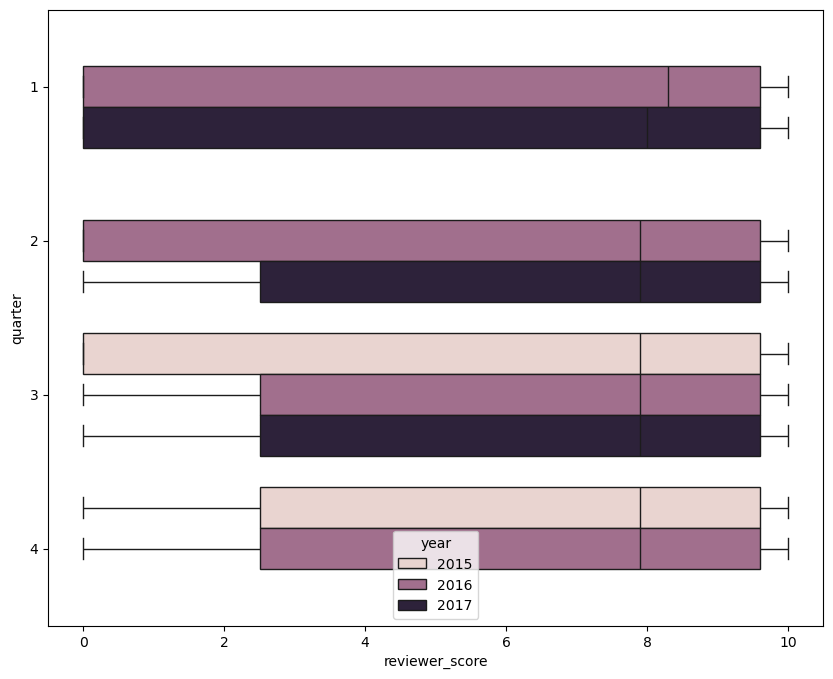

In [46]:
plt.figure(figsize = (10,8))
sns.boxplot(data=data, x='reviewer_score', y='quarter', orient='h', hue='year')

Вывод: отличие медианного показателя оценки заметно только в первом квартале 2016 года. Думаю, эти признаки не являются значимыми. Удалим их. 

In [47]:
data = data.drop(['review_date', 'quarter', 'year'], axis=1)

Посмотрим, есть ли пропуски в получившемся датасете.

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 65 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   name_hotel                                  515738 non-null  int64  
 

Вывод: пропуски есть в признаке nights. Заполним эти пропуски нулями.

In [49]:
data.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 65 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   name_hotel                                  515738 non-null  int64  
 

In [50]:
data.nunique(dropna=False)

average_score                                   34
review_total_negative_word_counts              402
review_total_positive_word_counts              365
total_number_of_reviews_reviewer_has_given     198
days_since_review                              731
                                              ... 
reviewer_nationality_4                           2
reviewer_nationality_5                           2
reviewer_nationality_6                           2
reviewer_nationality_7                           2
total_number_of_scoring_normalized            1201
Length: 65, dtype: int64

<Axes: >

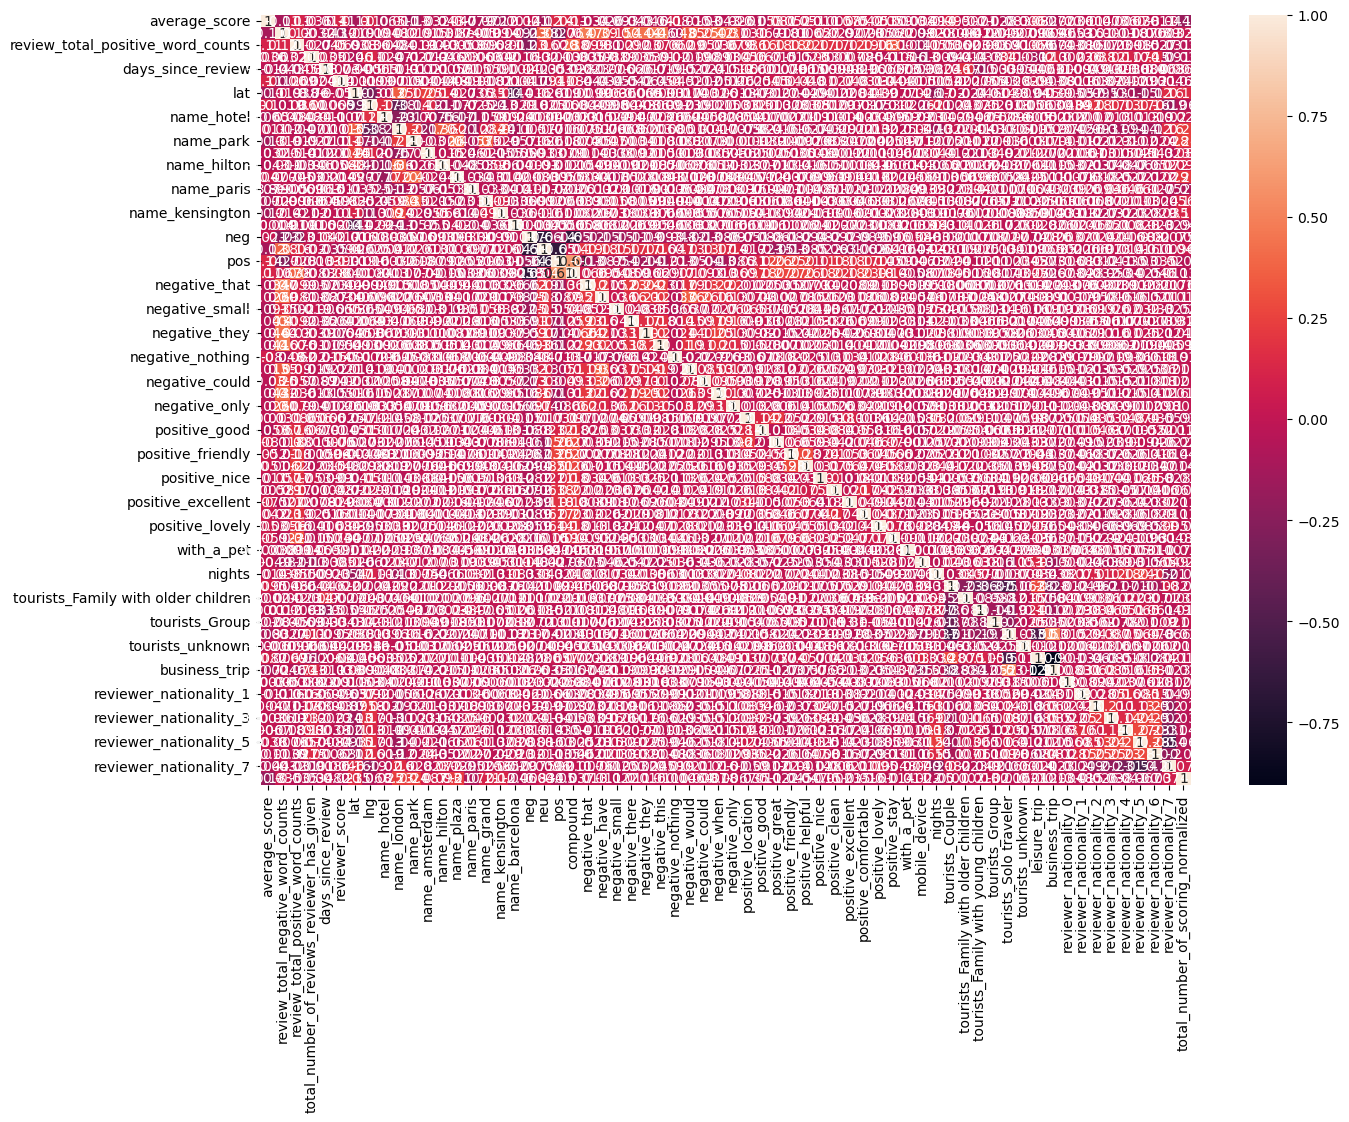

In [51]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Тепловая матрица корреляций практически нечитаема из-за очень большого количества признаков. Попробуем отфильтровать только признаки с высокой корреляцией.

<Axes: >

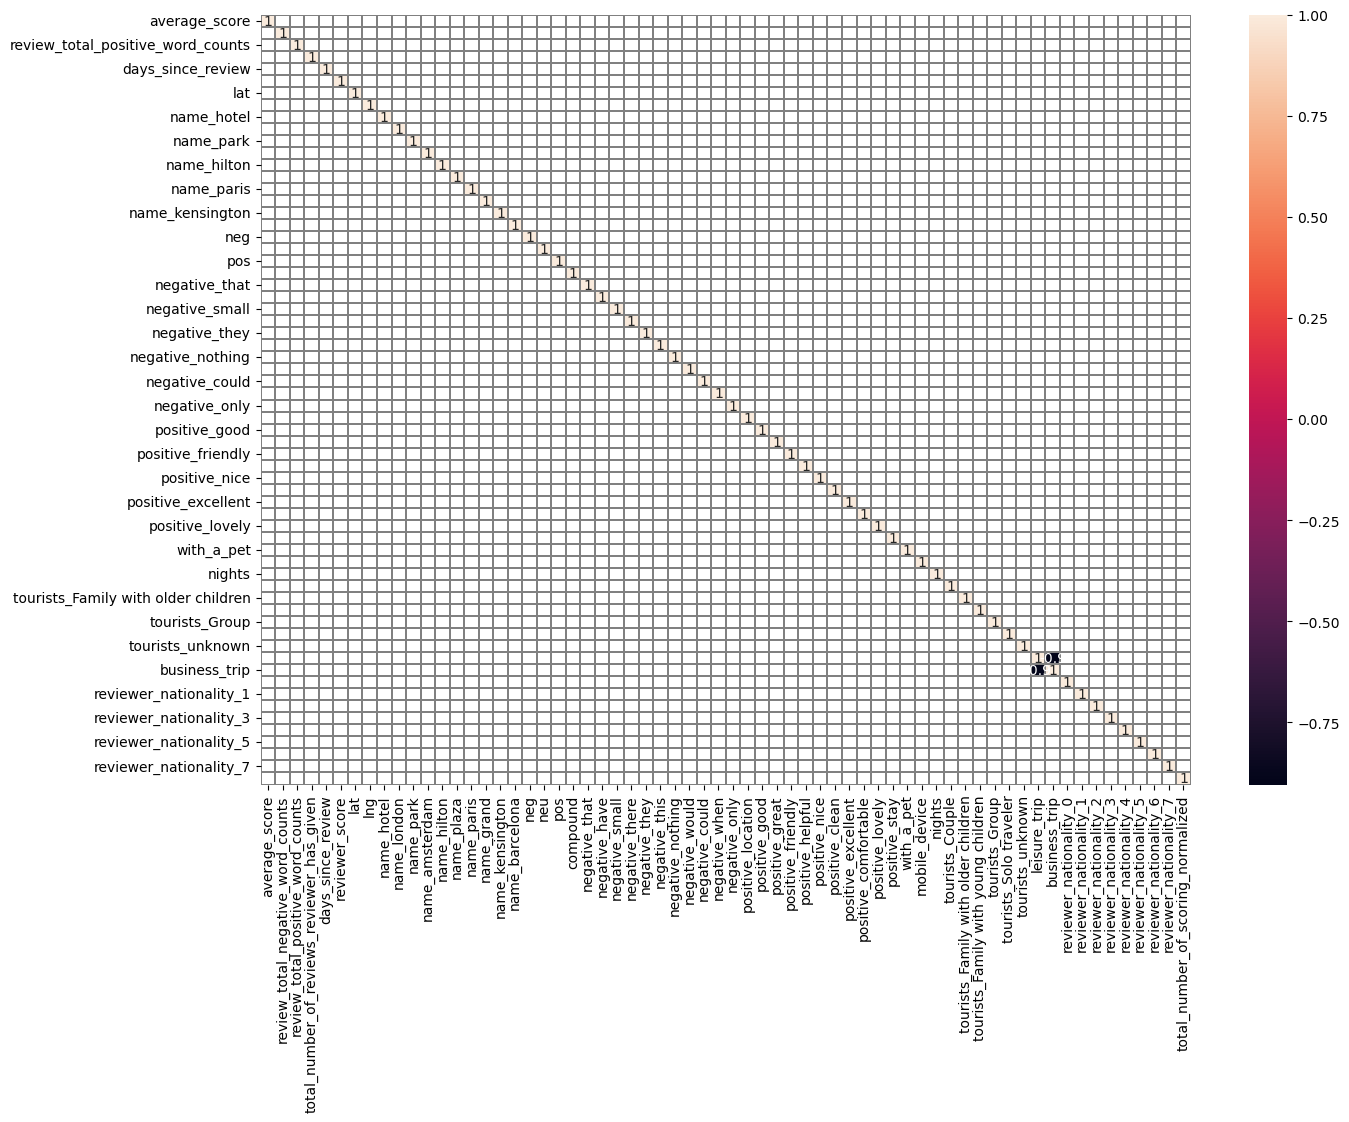

In [52]:
corr = data.drop(['sample'], axis=1).corr()
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(corr, mask=abs(corr) <= 0.7, linewidths=0.01, linecolor='gray', annot=True)


Видим, что признаки 'business_trip' и 'leisure_trip' очень сильно коррелируют между собой. Фактически, они сообщают одну и ту же информацию. Оставим только один из них, а второй удалим. 

In [53]:
data = data.drop(['leisure_trip'], axis=1)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   name_hotel                                  515738 non-null  int64  
 

Пропусков в датасете больше нет. 

# Предсказание reviewer_score

In [55]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 63), (386803, 63), (386803, 62), (309442, 62), (77361, 62))

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [60]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  6.5min finished


In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE)  
# Она показывает среднее абсолютное отклонение прогнозируемых значений от фактических значений в процентах.

# Попытка использовать здесь встроенную в sclearn.metrics функцию рассчета MAPE (metrics.mean_absolute_percentage_error) вызывает ошибку.
# Создадим функцию для вычисления MAPE на основе библиотеки NumPy.

def mape_func(Y_actual, Y_predicted):
    mape = np.mean(np.abs((Y_actual - Y_predicted) / Y_actual)) * 100
    return mape

print('MAPE:', mape_func(y_test, y_pred))

MAPE: 12.382919821432735


<Axes: >

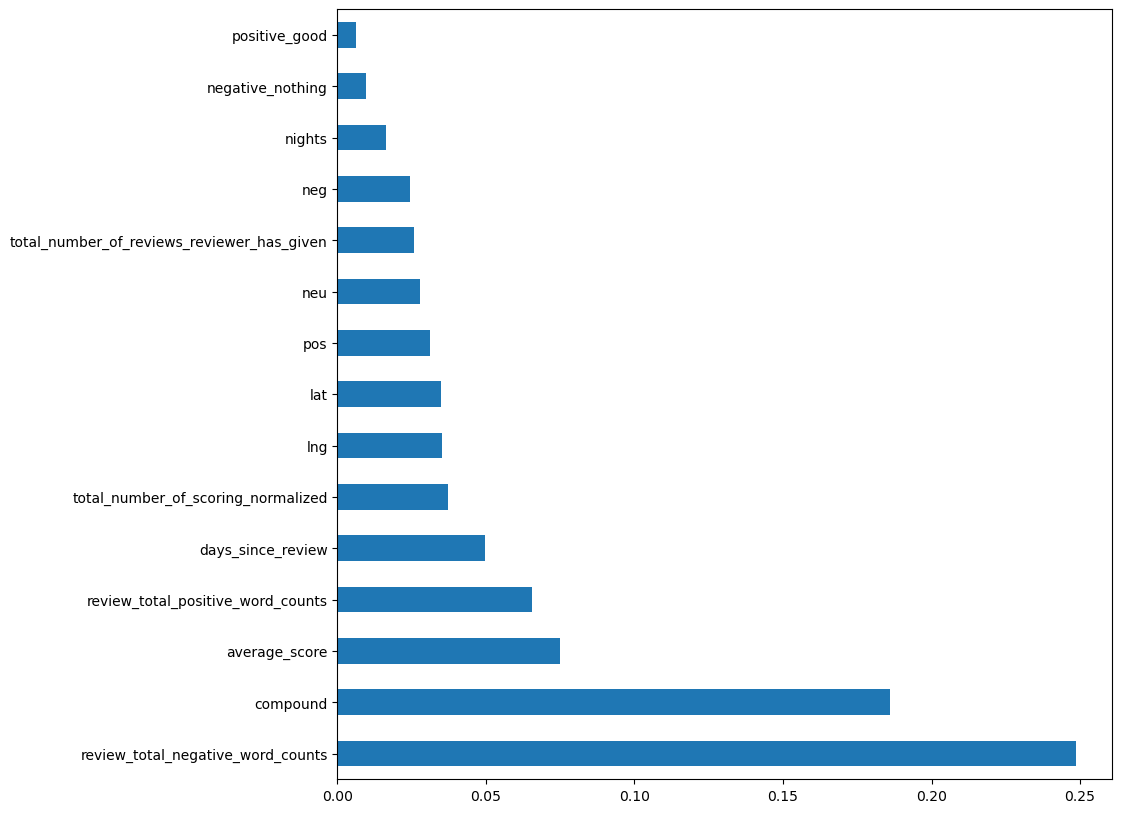

In [62]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')